Install Dependencies

In [10]:
!pip install yt-dlp fastdtw mediapipe opencv-python-headless --quiet

Download and Trim Videos

In [11]:
# Download reference and user videos from YouTube
!yt-dlp -f bestvideo+bestaudio --merge-output-format mp4 "https://www.youtube.com/watch?v=a72NCO0OFXA" -o "dance.mp4"
!yt-dlp -f bestvideo+bestaudio --merge-output-format mp4 "https://www.youtube.com/watch?v=wxEmSmDQEuU" -o "user.mp4"

# Trim the videos to the desired start time (keep everything after that point)
!ffmpeg -ss 00:00:09 -i "dance.mp4" -c copy "dance_trimmed.mp4"
!ffmpeg -ss 00:00:11 -i "user.mp4" -c copy "user_trimmed.mp4"

[youtube] Extracting URL: https://www.youtube.com/watch?v=a72NCO0OFXA
[youtube] a72NCO0OFXA: Downloading webpage
[youtube] a72NCO0OFXA: Downloading tv client config
[youtube] a72NCO0OFXA: Downloading tv player API JSON
[youtube] a72NCO0OFXA: Downloading ios player API JSON
[youtube] a72NCO0OFXA: Downloading m3u8 information
[info] a72NCO0OFXA: Downloading 1 format(s): 397+251
[download] dance.mp4 has already been downloaded
[youtube] Extracting URL: https://www.youtube.com/watch?v=wxEmSmDQEuU
[youtube] wxEmSmDQEuU: Downloading webpage
[youtube] wxEmSmDQEuU: Downloading tv client config
[youtube] wxEmSmDQEuU: Downloading tv player API JSON
[youtube] wxEmSmDQEuU: Downloading ios player API JSON
[youtube] wxEmSmDQEuU: Downloading m3u8 information
[info] wxEmSmDQEuU: Downloading 1 format(s): 397+251
[download] user.mp4 has already been downloaded
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration

Extract Frames

In [12]:
import os

def extract_frames_with_ffmpeg(video_path, output_dir, fps=2):
    os.makedirs(output_dir, exist_ok=True)
    # This command extracts 2 frames per second from the video
    cmd = f"ffmpeg -i \"{video_path}\" -vf fps={fps} \"{output_dir}/frame_%04d.jpg\" -hide_banner -loglevel error"
    os.system(cmd)

# Extract frames from the trimmed videos
extract_frames_with_ffmpeg("dance_trimmed.mp4", "frames_ref", fps=2)
extract_frames_with_ffmpeg("user_trimmed.mp4", "frames_user", fps=2)

Extract Poses from Frames

In [13]:
import mediapipe as mp
import numpy as np
import cv2
from tqdm import tqdm

# Use MediaPipe's Pose module
mp_pose = mp.solutions.pose

def extract_pose_from_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    with mp_pose.Pose(static_image_mode=True) as pose:
        for fname in tqdm(sorted(os.listdir(image_dir))):
            if not fname.endswith(".jpg"):
                continue  # Skip non-image files

            img_path = os.path.join(image_dir, fname)
            image_bgr = cv2.imread(img_path)
            if image_bgr is None:
                continue  # Skip if the image failed to load

            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            # If pose landmarks are found, save them as .npy
            if results.pose_landmarks:
                keypoints = [(lm.x, lm.y) for lm in results.pose_landmarks.landmark]
                keypoints = np.array(keypoints)
                np.save(os.path.join(output_dir, fname.replace(".jpg", ".npy")), keypoints)

# Run pose extraction on both reference and user frames
extract_pose_from_images("frames_ref", "pose_data/gukmin")
extract_pose_from_images("frames_user", "pose_data/user_trial_01")


100%|██████████| 593/593 [00:20<00:00, 28.86it/s]


Load Pose Sequences

In [14]:
def load_pose_sequence(npy_dir):
    # Load all .npy files in order and return as a list of pose frames
    files = sorted(f for f in os.listdir(npy_dir) if f.endswith(".npy"))
    return np.array([np.load(os.path.join(npy_dir, f)) for f in files])

# Load reference and user pose sequences
ref_seq = load_pose_sequence("pose_data/gukmin")
usr_seq = load_pose_sequence("pose_data/user_trial_01")

Automatic DTW Shift Alignment

In [15]:
from fastdtw import fastdtw
from scipy.spatial.distance import cosine, euclidean

# Compute DTW distance between two pose sequences
def compute_dtw_distance(seq1, seq2):
    s1 = seq1.reshape(seq1.shape[0], -1)  # Flatten frames
    s2 = seq2.reshape(seq2.shape[0], -1)
    distance, _ = fastdtw(s1, s2, dist=euclidean)
    return distance

# Try different starting offsets to find best time alignment
def find_best_shift(ref_seq, usr_seq, max_shift=10):
    best_shift = 0
    best_distance = float("inf")
    best_aligned = None

    for shift in range(-max_shift, max_shift + 1):
        # Shift user sequence and trim both sequences to same length
        if shift >= 0:
            usr_cut = usr_seq[shift:]
            ref_cut = ref_seq[:len(usr_cut)]
        else:
            usr_cut = usr_seq[:shift]
            ref_cut = ref_seq[-shift:]

        min_len = min(len(ref_cut), len(usr_cut))
        if min_len == 0:
            continue

        # Compute DTW distance for this alignment
        distance = compute_dtw_distance(ref_cut[:min_len], usr_cut[:min_len])

        # Keep best (lowest) distance and aligned sequence
        if distance < best_distance:
            best_distance = distance
            best_shift = shift
            best_aligned = usr_cut[:min_len]

    return best_shift, best_distance, best_aligned

# Run the shift finder
shift, dtw_distance, aligned_usr = find_best_shift(ref_seq, usr_seq)

Cosine Similarity

In [16]:
def frame_cosine_similarity(p1, p2):
    # Compare two pose frames (flattened) using cosine similarity
    return 1 - cosine(p1.flatten(), p2.flatten())

# Align both sequences to the same length
min_len = min(len(ref_seq), len(aligned_usr))
ref_seq = ref_seq[:min_len]
aligned_usr = aligned_usr[:min_len]

# Compute similarity for each frame pair
cosine_scores = [frame_cosine_similarity(ref_seq[i], aligned_usr[i]) for i in range(min_len)]

Plot

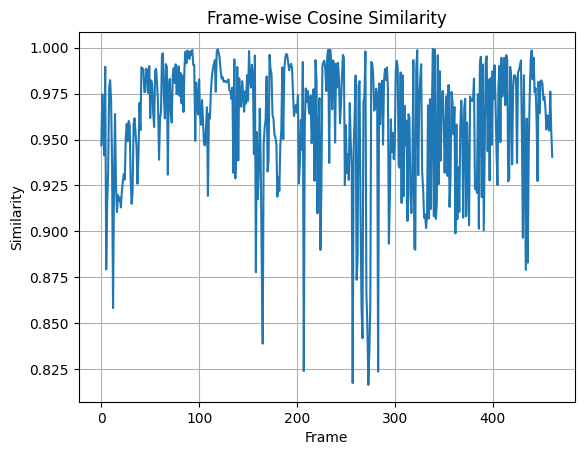

In [17]:
import matplotlib.pyplot as plt

plt.plot(cosine_scores)
plt.title("Frame-wise Cosine Similarity")
plt.xlabel("Frame")
plt.ylabel("Similarity")
plt.grid()
plt.show()

DTW Path

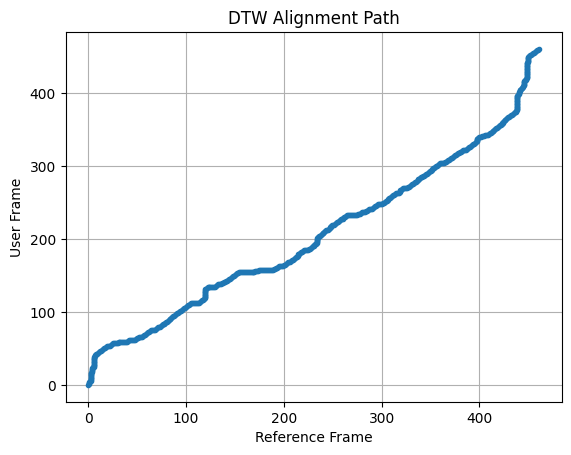

In [18]:
# Flatten pose sequences for DTW
ref_flat = ref_seq.reshape(ref_seq.shape[0], -1)
usr_flat = aligned_usr.reshape(aligned_usr.shape[0], -1)

# Get the DTW matching path between frames
_, path = fastdtw(ref_flat, usr_flat, dist=euclidean)

# Visualize frame-to-frame alignment
plt.plot([i for i, _ in path], [j for _, j in path], '.-')
plt.title("DTW Alignment Path")
plt.xlabel("Reference Frame")
plt.ylabel("User Frame")
plt.grid()
plt.show()

Score Summary (dtw_max = 2000)

In [19]:
def score_summary(cosine_scores, dtw_distance, dtw_max=2000):
    # Calculate average cosine similarity as a % score
    frame_score = np.mean(cosine_scores) * 100

    # DTW score: lower distance means higher score
    dtw_score = max(0, 100 * (1 - dtw_distance / dtw_max))

    # Combine both for final evaluation
    total_score = 0.5 * frame_score + 0.5 * dtw_score

    return {
        "Frame Avg. Score": round(frame_score, 2),
        "DTW Score": round(dtw_score, 2),
        "Total Score": round(total_score, 2)
    }

# Print results
summary = score_summary(cosine_scores, dtw_distance)
print("Shift:", shift)
print("DTW Distance:", round(dtw_distance, 2))
print(summary)

Shift: 3
DTW Distance: 628.94
{'Frame Avg. Score': 95.89, 'DTW Score': 68.55, 'Total Score': 82.22}
